# Hop ranges, slices, and labels

GFQL examples for bounded hops, output slices, and labeling (Cypher-style patterns like `(a)-[*2..4]->(b)`).

- Exact and ranged hops (`min_hops`/`max_hops`)
- Post-filtered output slices (`output_min_hops`/`output_max_hops`)
- Optional hop labels on nodes/edges; seeds = starting nodes (label seeds at hop 0 when requested)


Visual of the toy branching chain used below (seed at 'a').


In [1]:
import pandas as pd
import graphistry
from graphistry.compute.ast import is_in, n, e_forward

edges = pd.DataFrame({
    's': ['a', 'b1', 'c1', 'd1', 'a', 'b2'],
    'd': ['b1', 'c1', 'd1', 'e1', 'b2', 'c2']
})

nodes = pd.DataFrame({'id': ['a', 'b1', 'c1', 'd1', 'e1', 'b2', 'c2']})

g = graphistry.edges(edges, 's', 'd').nodes(nodes, 'id')
seed_ids = ['a']

print('Edges:')
print(edges)
print()
print('Nodes:')
print(nodes)
print()
print('Seed ids:', seed_ids)


Edges:
    s   d
0   a  b1
1  b1  c1
2  c1  d1
3  d1  e1
4   a  b2
5  b2  c2

Nodes:
   id
0   a
1  b1
2  c1
3  d1
4  e1
5  b2
6  c2

Seed ids: ['a']


In [2]:
from html import escape
import pandas as pd

# Fixed layout positions for the toy graph
pos_lookup = {
    'a': (50, 100),
    'b1': (150, 70),
    'c1': (250, 70),
    'd1': (350, 70),
    'e1': (450, 70),
    'b2': (150, 130),
    'c2': (250, 130),
}

_y_min = min(y for _, y in pos_lookup.values())
_y_max = max(y for _, y in pos_lookup.values())

def _flip_y(y):
    return _y_min + _y_max - y

def _format_label(val):
    if pd.isna(val):
        return None
    if isinstance(val, (int, float)) and float(val).is_integer():
        val = int(val)
    return str(val)

def _with_fixed_layout(g_out, label_col=None):
    if g_out._nodes is None or g_out._edges is None:
        return g_out
    node_col = g_out._node
    src_col, dst_col = g_out._source, g_out._destination
    nodes_df = g_out._nodes.copy()
    coords = nodes_df[node_col].map(pos_lookup)
    nodes_df['x'] = coords.map(lambda v: v[0] if v is not None else None)
    nodes_df['y'] = coords.map(lambda v: _flip_y(v[1]) if v is not None else None)
    nodes_df = nodes_df.dropna(subset=['x', 'y'])
    if label_col and label_col in nodes_df.columns:
        label_vals = nodes_df[label_col].map(_format_label)
        labels = []
        for node, label_val in zip(nodes_df[node_col], label_vals):
            if label_val is None:
                labels.append(escape(str(node)))
            else:
                labels.append(f"{escape(str(node))}:{escape(str(label_val))}")
        nodes_df = nodes_df.assign(label=labels)
    node_ids = set(nodes_df[node_col])
    edges_df = g_out._edges
    edges_df = edges_df[edges_df[src_col].isin(node_ids) & edges_df[dst_col].isin(node_ids)]
    return g_out.nodes(nodes_df).edges(edges_df)

def render_static(g_out, label_col=None, title=None):
    g_fixed = _with_fixed_layout(g_out, label_col=label_col)
    graph_attr = None
    if title:
        graph_attr = {
            'label': escape(title),
            'labelloc': 't',
            'fontsize': '14',
        }
    node_attr = {
        'shape': 'circle',
        'style': 'filled',
        'fillcolor': '#eef3ff',
        'color': '#1f4b99',
        'fontcolor': '#0a1a2f',
        'fontsize': '14',
    }
    edge_attr = {
        'color': '#1f4b99',
        'penwidth': '2',
    }
    return g_fixed.plot_static(
        engine='graphviz-svg',
        reuse_layout=True,
        graph_attr=graph_attr,
        node_attr=node_attr,
        edge_attr=edge_attr,
    )

# Fill missing hop labels from edge hops (keeps seeds unlabeled when excluded)
def fill_hops(g_out, label_col='hop', edge_label_col='edge_hop', seeds=None):
    if g_out._nodes is None or g_out._edges is None:
        return g_out
    if label_col not in g_out._nodes.columns or edge_label_col not in g_out._edges.columns:
        return g_out
    nodes_df = g_out._nodes.copy()
    edges_df = g_out._edges
    hop_map = pd.concat([
        edges_df[[g._source, edge_label_col]].rename(columns={g._source: g._node}),
        edges_df[[g._destination, edge_label_col]].rename(columns={g._destination: g._node}),
    ], ignore_index=True, sort=False).groupby(g._node)[edge_label_col].min()
    mask = nodes_df[label_col].isna()
    if seeds is not None:
        mask = mask & ~nodes_df[g._node].isin(seeds)
    if mask.any():
        nodes_df.loc[mask, label_col] = nodes_df.loc[mask, g._node].map(hop_map)
    try:
        nodes_df[label_col] = pd.to_numeric(nodes_df[label_col], errors='coerce').astype('Int64')
    except Exception:
        pass
    return g_out.nodes(nodes_df)


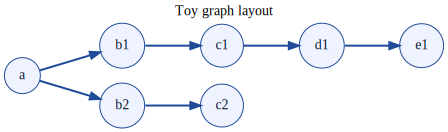

In [3]:
display(render_static(g, label_col=None, title='Toy graph layout'))


## Exact hops
Exact-hop GFQL edge calls for quick sanity checks before slicing or labeling.


Exactly 1 hop from seed 'a' to its immediate neighbors (no labels).


1-hop nodes from 'a' (first hop):
   id  __gfql_output_node_hop__
0   a                      <NA>
1  b1                         1
2  b2                         1

1-hop edges:
   __gfql_output_edge_hop__  s   d
0                         1  a  b1
1                         1  a  b2


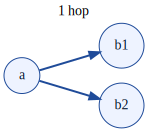

In [4]:
# Exactly 1 hop (no labels)
hop_1 = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=1, max_hops=1),
])

print("1-hop nodes from 'a' (first hop):")
print(hop_1._nodes.sort_values(g._node))
print()
print('1-hop edges:')
print(hop_1._edges.sort_values([g._source, g._destination]))
display(render_static(hop_1, label_col=None, title='1 hop'))

Exactly 3 hops bounded to three steps; default output keeps the earlier hops for context (no labels).


3-hop nodes from 'a' (path to third hop):
   id  __gfql_output_node_hop__
0   a                      <NA>
1  b1                         1
2  c1                         2
3  d1                         3

3-hop edges:
   __gfql_output_edge_hop__   s   d
0                         1   a  b1
1                         2  b1  c1
2                         3  c1  d1


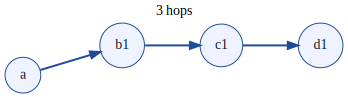

In [5]:

# Exactly 3 hops (no labels, default keeps path)
hop_3 = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=3, max_hops=3),
])

print("3-hop nodes from 'a' (path to third hop):")
print(hop_3._nodes.sort_values(g._node))
print()
print('3-hop edges:')
print(hop_3._edges.sort_values([g._source, g._destination]))
display(render_static(hop_3, label_col=None, title='3 hops'))


## Hop ranges
Variable-length traversal with full-path output (keep hops up to the bound).


Range 1..3 hops from 'a' (unlabeled) to mirror a Cypher pattern like `(a)-[*1..3]->(?)`.


Nodes within 1..3 hops from 'a':
   id  __gfql_output_node_hop__
0   a                      <NA>
1  b1                         1
3  b2                         1
2  c1                         2
5  c2                         2
4  d1                         3

Edges within 1..3 hops:
   __gfql_output_edge_hop__   s   d
0                         1   a  b1
3                         1   a  b2
1                         2  b1  c1
4                         2  b2  c2
2                         3  c1  d1


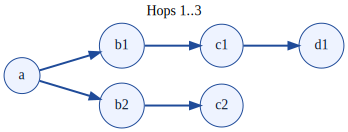

In [6]:
# Range 1..3 hops (combined)
hop_range = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=1, max_hops=3),
])

print("Nodes within 1..3 hops from 'a':")
print(hop_range._nodes.sort_values(g._node))
print()
print('Edges within 1..3 hops:')
print(hop_range._edges.sort_values([g._source, g._destination]))
display(render_static(hop_range, label_col=None, title='Hops 1..3'))

## Output slicing
Post-filter the traversal results without changing the traversal itself.


Traverse 2..4 hops but only display hops 3..4, with hop numbers on nodes/edges.


Nodes in hops 3..4 (after traversing 2..4):
   id  hop
2  c1    3
0  d1    3
1  e1    4

Edges in hops 3..4:
   edge_hop   s   d
0         3  c1  d1
1         4  d1  e1


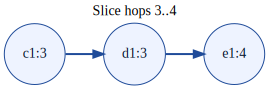

In [7]:
# Traverse 2..4 hops; output slice 3..4 with hop labels
hop_slice = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=2, max_hops=4, output_min_hops=3, output_max_hops=4, label_node_hops='hop', label_edge_hops='edge_hop'),
])
hop_slice = fill_hops(hop_slice, seeds=seed_ids)

print('Nodes in hops 3..4 (after traversing 2..4):')
print(hop_slice._nodes.sort_values(['hop', g._node]))
print()
print('Edges in hops 3..4:')
print(hop_slice._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_static(hop_slice, label_col='hop', title='Slice hops 3..4'))

Output_min below min_hops: keep the lead-in hops and label the seed at hop 0.


Nodes when output_min < min_hops (labels on, seeds labeled):
   id  hop
0   a    0
1  b1    1
2  c1    2
3  d1    3

Edges when output_min < min_hops:
   edge_hop   s   d
0         1   a  b1
1         2  b1  c1
2         3  c1  d1


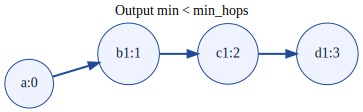

In [8]:
# Output slice below traversal min (keeps earlier hops)
hop_slice_below = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=3, max_hops=3, output_min_hops=1, label_node_hops='hop', label_edge_hops='edge_hop', label_seeds=True),
])
hop_slice_below = fill_hops(hop_slice_below, seeds=seed_ids)

print('Nodes when output_min < min_hops (labels on, seeds labeled):')
print(hop_slice_below._nodes.sort_values(['hop', g._node]))
print()
print('Edges when output_min < min_hops:')
print(hop_slice_below._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_static(hop_slice_below, label_col='hop', title='Output min < min_hops'))

Output_max above traversal: slice is capped at traversal depth; edge labels show the cap.


Edges when output_max > traversal max (still capped at traversal):
   edge_hop   s   d
0         1   a  b1
2         1   a  b2
1         2  b1  c1
3         2  b2  c2


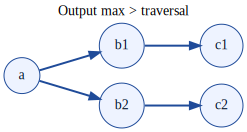

In [9]:
# Output slice max above traversal max (allowed, capped by traversal)
hop_slice_above = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=2, max_hops=2, output_max_hops=5, label_edge_hops='edge_hop'),
])

print('Edges when output_max > traversal max (still capped at traversal):')
print(hop_slice_above._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_static(hop_slice_above, label_col=None, title='Output max > traversal'))

Invalid output slices: examples of raised validation errors for mismatched bounds.


In [10]:
# Invalid output slice (output_min > max_hops)
bad_output_min_chain = [
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=2, max_hops=3, output_min_hops=5),
]

# Invalid output slice (output_max < min_hops)
bad_output_max_chain = [
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=2, max_hops=3, output_max_hops=1),
]
try:
    g.gfql(bad_output_max_chain)
except Exception as e:
    print('Invalid output_max < min_hops:', e)

Invalid output_max < min_hops: [invalid-hops-value] output_max_hops cannot be below min_hops traversal bound | field: output_max_hops | value: 1 | suggestion: Raise output_max_hops or lower min_hops


## Labels
Compare hop labels with and without labeling the seeds.


Labels without seeds: hop numbers start at 1 for new nodes/edges; seed 'a' stays unlabeled.


Nodes with hop labels (seeds not labeled):
   id   hop
1  b1     1
3  b2     1
2  c1     2
5  c2     2
4  d1     3
0   a  <NA>

Edges with hop labels (seeds not labeled):
   edge_hop   s   d
0         1   a  b1
3         1   a  b2
1         2  b1  c1
4         2  b2  c2
2         3  c1  d1


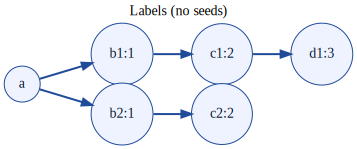

In [11]:
# Hop labels without seed labels
hop_labels_off = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=1, max_hops=3, label_node_hops='hop', label_edge_hops='edge_hop', label_seeds=False),
])
hop_labels_off = fill_hops(hop_labels_off, seeds=seed_ids)

print('Nodes with hop labels (seeds not labeled):')
print(hop_labels_off._nodes.sort_values(['hop', g._node]))
print()
print('Edges with hop labels (seeds not labeled):')
print(hop_labels_off._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_static(hop_labels_off, label_col='hop', title='Labels (no seeds)'))

Labels with seeds: seed labeled hop 0; downstream hops increment from there.


Nodes with hop labels (seeds labeled hop=0):
   id  hop
0   a    0
1  b1    1
2  b2    1
3  c1    2
4  c2    2
5  d1    3

Edges with hop labels (seeds labeled hop=0):
   edge_hop   s   d
0         1   a  b1
3         1   a  b2
1         2  b1  c1
4         2  b2  c2
2         3  c1  d1


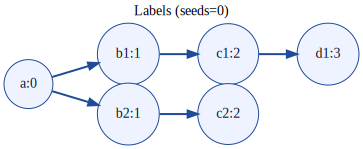

In [12]:
# Hop labels with seed labels
hop_labels_on = g.gfql([
    n({g._node: is_in(seed_ids)}),
    e_forward(min_hops=1, max_hops=3, label_node_hops='hop', label_edge_hops='edge_hop', label_seeds=True),
])
hop_labels_on = fill_hops(hop_labels_on, seeds=seed_ids)

print('Nodes with hop labels (seeds labeled hop=0):')
print(hop_labels_on._nodes.sort_values(['hop', g._node]))
print()
print('Edges with hop labels (seeds labeled hop=0):')
print(hop_labels_on._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_static(hop_labels_on, label_col='hop', title='Labels (seeds=0)'))